In [1]:
import sys
sys.path.append('..')

from utils import *
from data_utils import *
from metrics import *
from plots import *

## Testing dataset generation 

In [2]:
from sklearn.metrics import classification_report

def eval(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(len(set(all_labels)))]))

    return acc


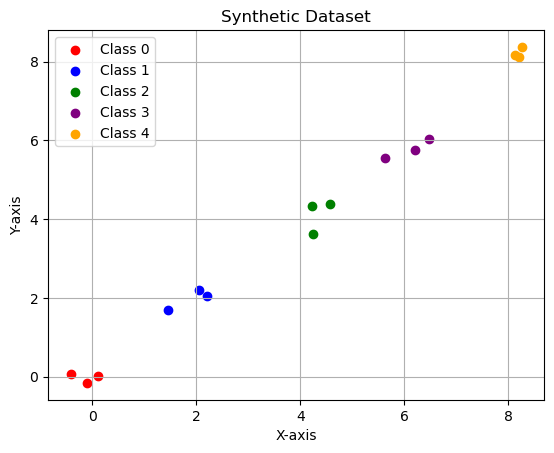

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_classes, n_points, base_covariance, shift, start_mean=0.0):
    """
    Generate synthetic data.
    
    Parameters:
        n_classes (int): The number of classes.
        n_points (int): The number of points per class.
        base_covariance (list of list of float): The base covariance matrix for generating points.
        shift (float): The shift in the mean for each subsequent class.
        
    Returns:
        X (np.ndarray): The feature array.
        y (np.ndarray): The label array.
    """
    
    X_list = []
    y_list = []
    
    for i in range(n_classes):
        # Mean for class i (shifted along the line y=x)
        mean = [start_mean + i * shift, start_mean + i * shift]
        
        # Generate points for class i
        x, y = np.random.multivariate_normal(mean, base_covariance, n_points).T
        
        # Labels for the points
        labels = np.full(n_points, i, dtype=int)
        
        X_list.append(np.column_stack((x, y)))
        y_list.append(labels)
        
    # Combine the points and labels
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    
    # Shuffle the dataset
    shuffle_indices = np.random.permutation(n_classes * n_points)
    X = X[shuffle_indices]
    y = y[shuffle_indices]
    
    return X, y

# Seed for reproducibility
np.random.seed(42)

# Number of classes
n_classes = 5

# Number of points per class
n_points = 3

# Base covariance matrix for generating points
base_covariance = [[0.1, 0.05], [0.05, 0.1]]

# Shift in mean for each subsequent class
shift = 2.0

# Generate the data
X, y = generate_data(n_classes, n_points, base_covariance, shift)

# Plot the dataset
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(n_classes):
    plt.scatter(X[y==i][:, 0], X[y==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')

plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Synthetic Dataset')
plt.grid(True)
plt.show()


## Pretraining

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [5]:
device = 'cpu'

depth = 10

params = dict(device=device,
                width=50, lr=0.001, num_train=50,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 5, activation_function='tanh')

# Generate the synthetic dataset
n_classes = 5
n_points = 100
base_covariance = [[0.1, 0.05], [0.05, 0.1]]
shift = 2.0
X, y = generate_data(n_classes, n_points, base_covariance, shift)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Create DNN model
input_dim = 2  # 2D data points
output_dim = n_classes  # Number of classes
model = generate_fc_dnn(input_dim, output_dim, params)
#model = generate_fc_dnn_relu(input_dim, output_dim, params)


# Create a 'Namespace' to supply to the training function (to comply with your function's requirements)
from types import SimpleNamespace
dataset_namespace = SimpleNamespace(train_loader=train_loader, test_loader=test_loader, val_loader=test_loader)

# Train and evaluate
train_acc, test_acc, model, _ = compute_training_acc_epochs(model, dataset_namespace, params, debug=True)

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 73.20%
Validation Accuracy: 73.20%
Epoch: 1 	Training Accuracy: 90.60%
Validation Accuracy: 90.60%
Epoch: 2 	Training Accuracy: 97.80%
Validation Accuracy: 97.80%
Epoch: 3 	Training Accuracy: 98.80%
Validation Accuracy: 98.80%
Epoch: 4 	Training Accuracy: 91.20%
Validation Accuracy: 91.20%
val_acc: 0.912, max_val_acc: 0.988, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 98.60%
Validation Accuracy: 98.60%
val_acc: 0.986, max_val_acc: 0.988, no_improve_epochs: 2
Epoch: 6 	Training Accuracy: 97.60%
Validation Accuracy: 97.60%
val_acc: 0.976, max_val_acc: 0.988, no_improve_epochs: 3
Epoch: 7 	Training Accuracy: 97.80%
Validation Accuracy: 97.80%
val_acc: 0.978, max_val_acc: 0.988, no_improve_epochs: 4
Epoch: 8 	Training Accuracy: 99.20%
Validation Accuracy: 99.20%
Epoch: 9 	Training Accuracy: 99.60%
Validation Accuracy: 99.60%
Epoch: 10 	Training Accuracy: 99.40%
Validation Accuracy: 99.40%
val_acc: 0.994, max_val_acc: 0.996, no_improve_epochs: 1
Epoch: 11 

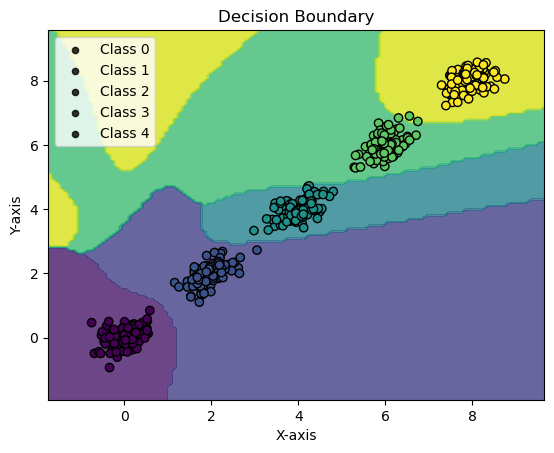

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_decision_boundary(model, X, y, n_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

# After training
plot_decision_boundary(model, X, y, n_classes)


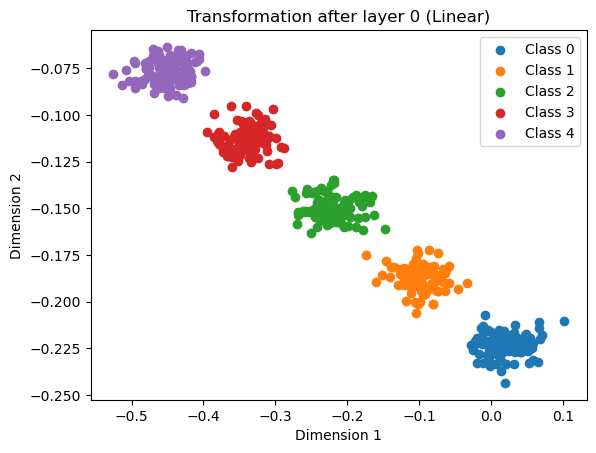

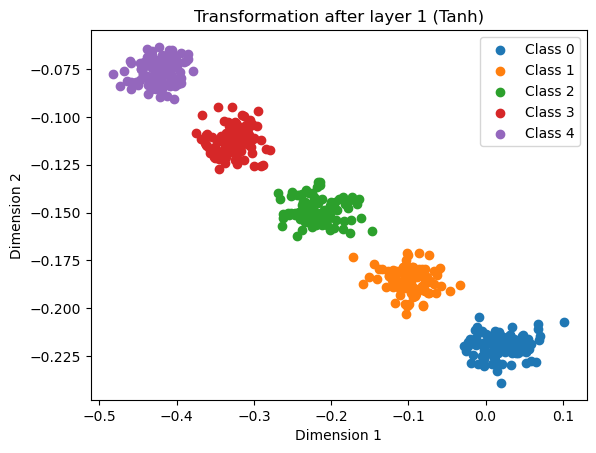

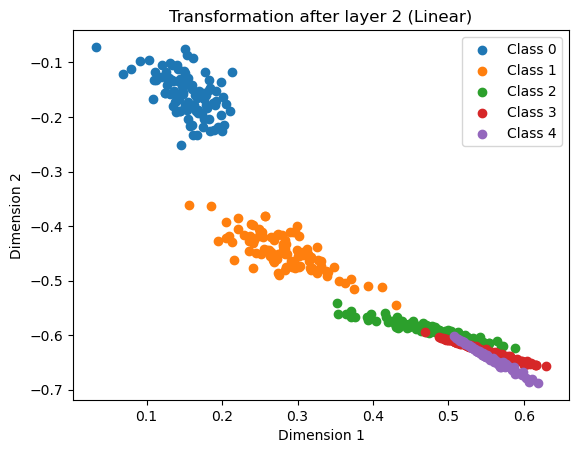

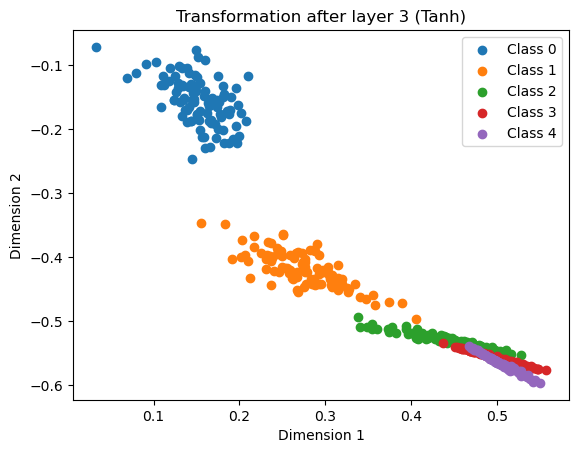

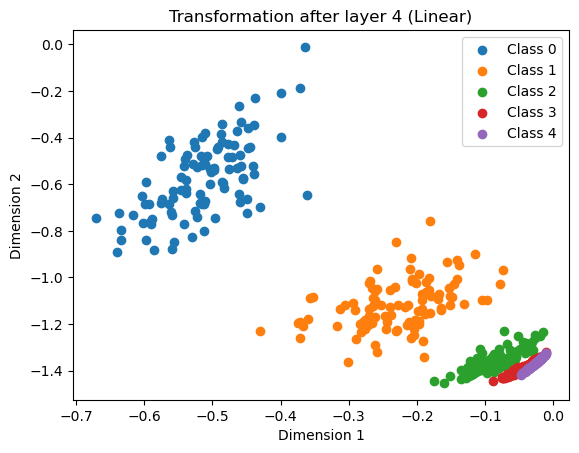

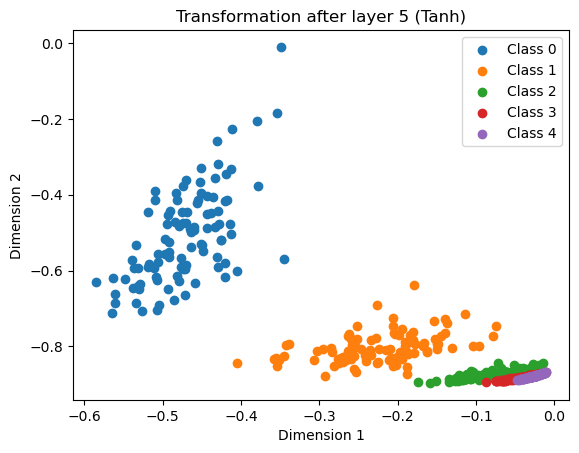

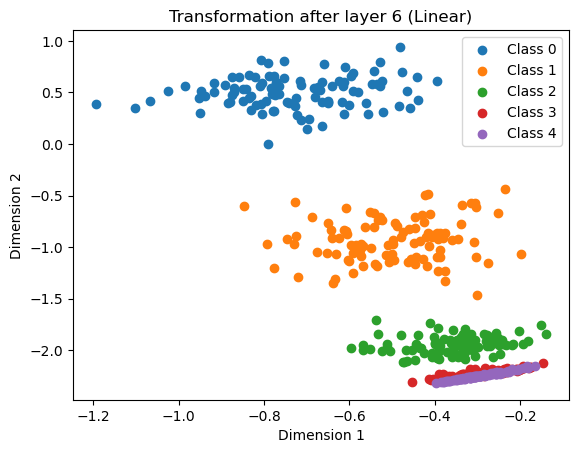

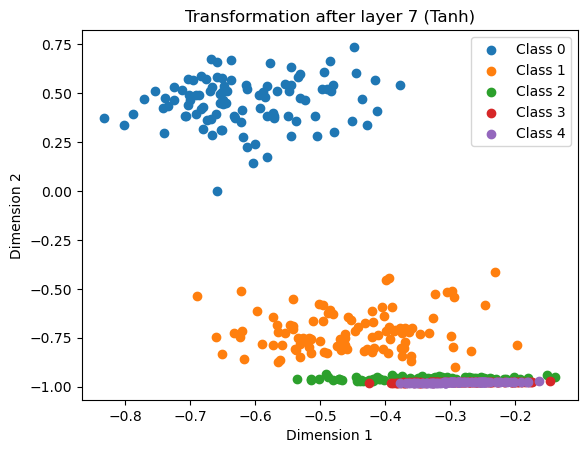

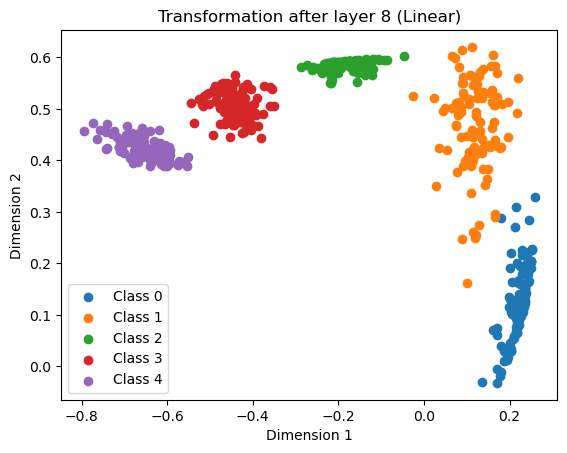

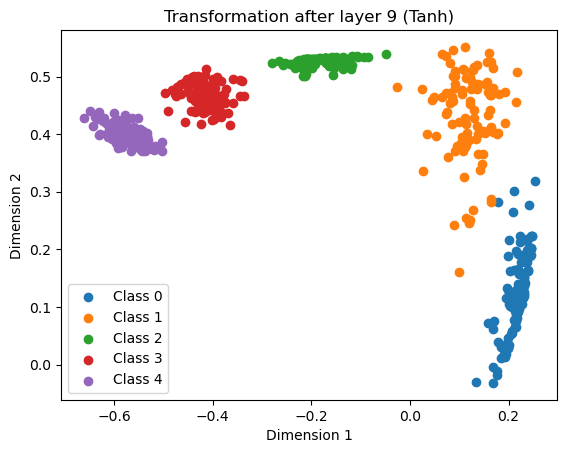

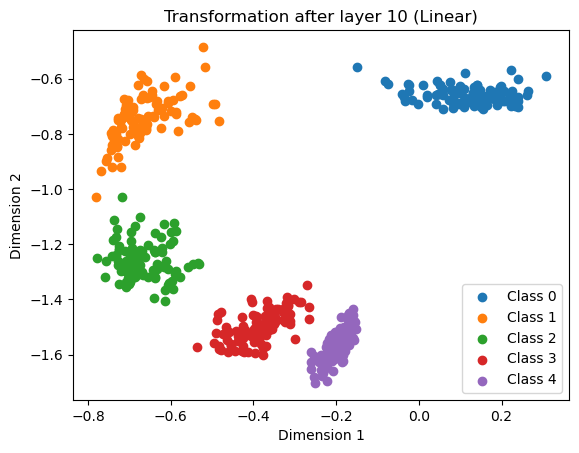

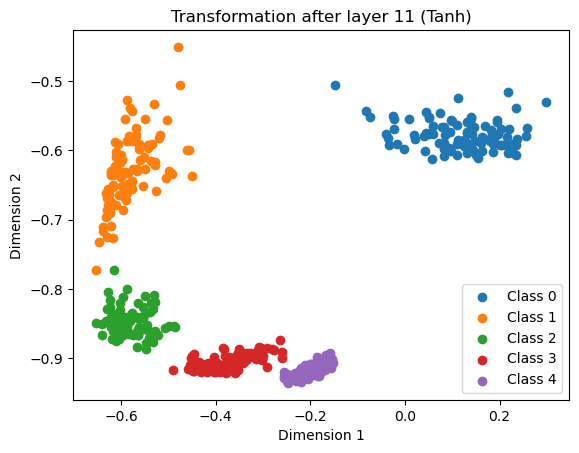

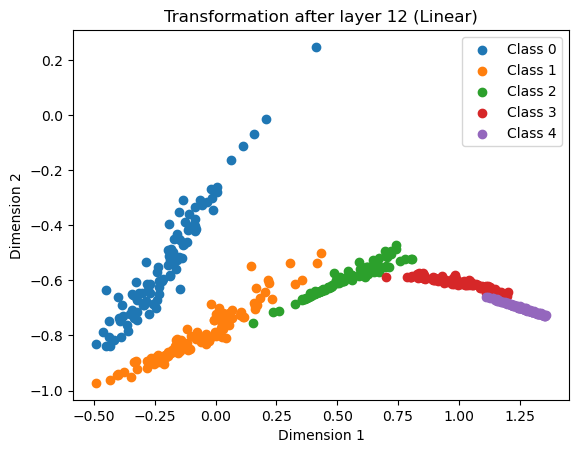

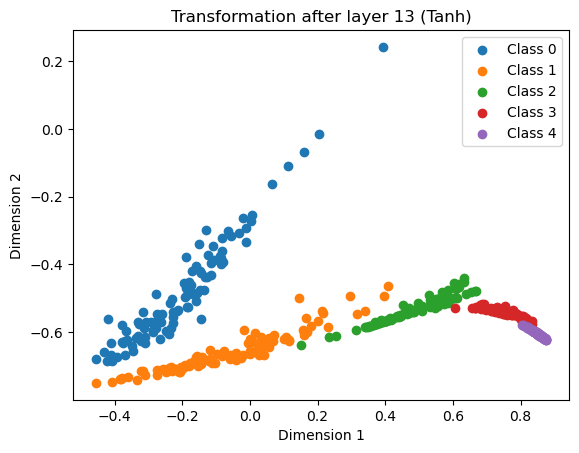

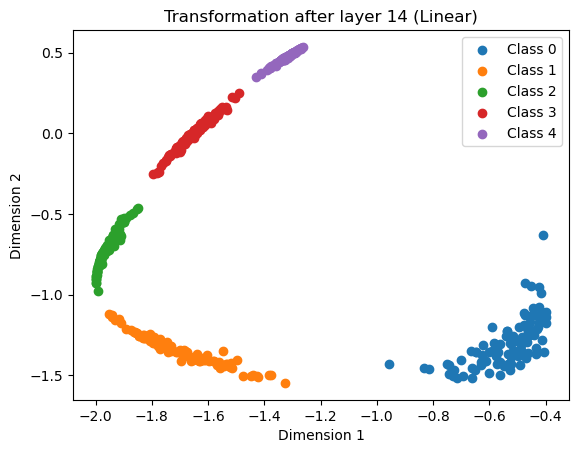

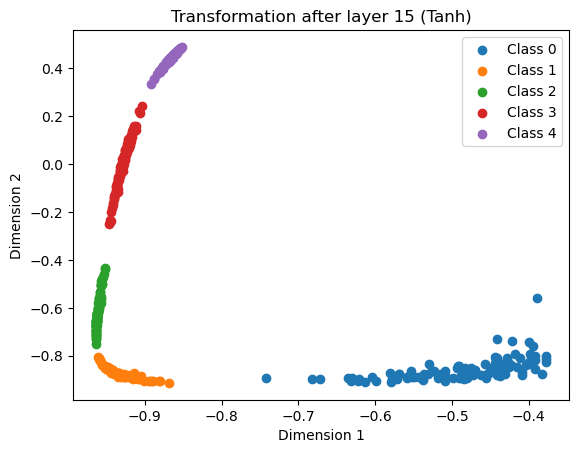

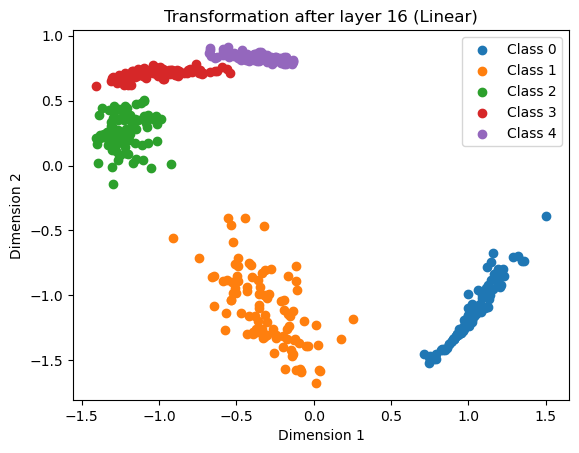

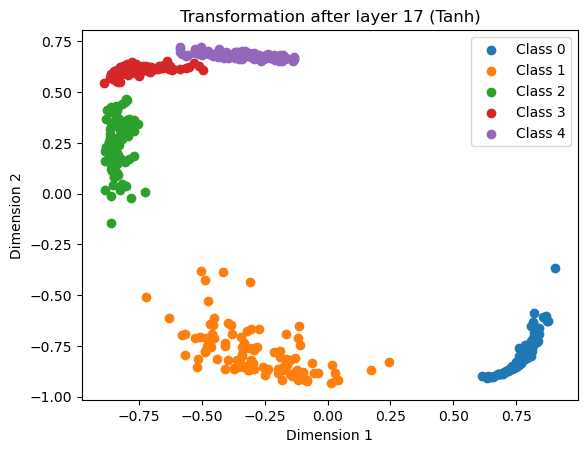

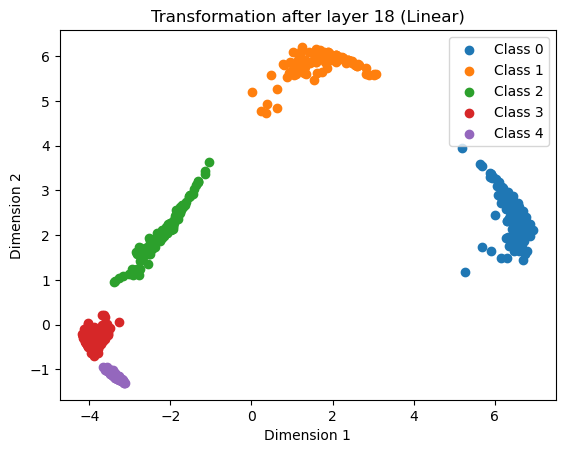

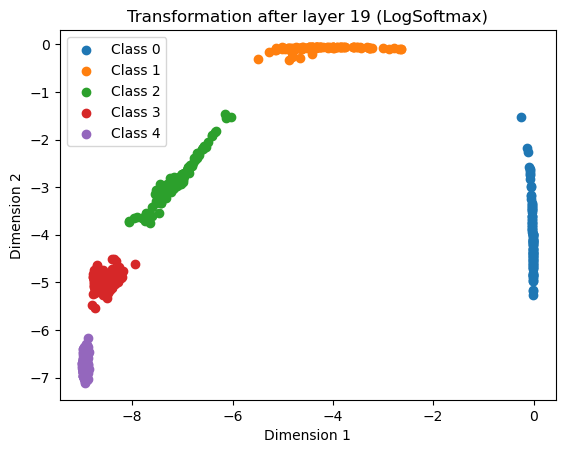

In [7]:
import matplotlib.pyplot as plt

def plot_layer_transformations(model, X, y, layer_indices):
    n_classes = len(np.unique(y))
    X_transformed = torch.FloatTensor(X)
    
    for i, layer_index in enumerate(layer_indices):
        layer = model[layer_index]
        
        with torch.no_grad():
            X_transformed = layer(X_transformed)
            
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Tanh) or isinstance(layer, nn.LogSoftmax):
            X_transformed_numpy = X_transformed.detach().cpu().numpy()
            
            plt.figure()
            for class_idx in range(n_classes):
                idxs = np.where(y == class_idx)[0]
                plt.scatter(X_transformed_numpy[idxs, 0], X_transformed_numpy[idxs, 1], label=f"Class {class_idx}")
            
            layer_type = type(layer).__name__
            plt.title(f'Transformation after layer {layer_index} ({layer_type})')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.legend()

# Indicate which layers you are interested in (by index).
layer_indices = list(range(depth*2))

# X should be your original data and y should be the labels.
plot_layer_transformations(model, X, y, layer_indices)

plt.show()


In [8]:
eval(model, device, test_loader, debug=True)


Train set: Average loss: 0.1637, Accuracy: 498.0/500 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       100
     Class 1       1.00      1.00      1.00       100
     Class 2       1.00      1.00      1.00       100
     Class 3       1.00      0.98      0.99       100
     Class 4       0.98      1.00      0.99       100

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



0.996

In [9]:
#save model
# torch.save(model, f"model_{depth}_synthetic_data_against_overfitting.pt")

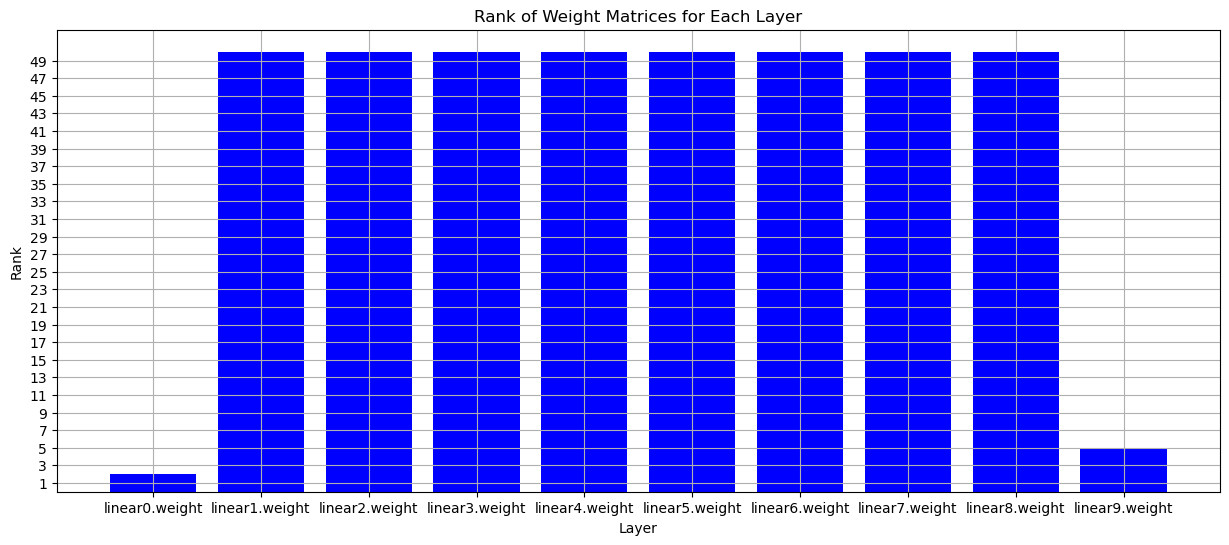

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_layer_ranks(model):
    ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            rank = np.linalg.matrix_rank(weight_matrix)
            ranks.append(rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(layer_names, ranks, color='blue')
    plt.xlabel('Layer')
    plt.ylabel('Rank')
    plt.title('Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(y_min, y_max, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


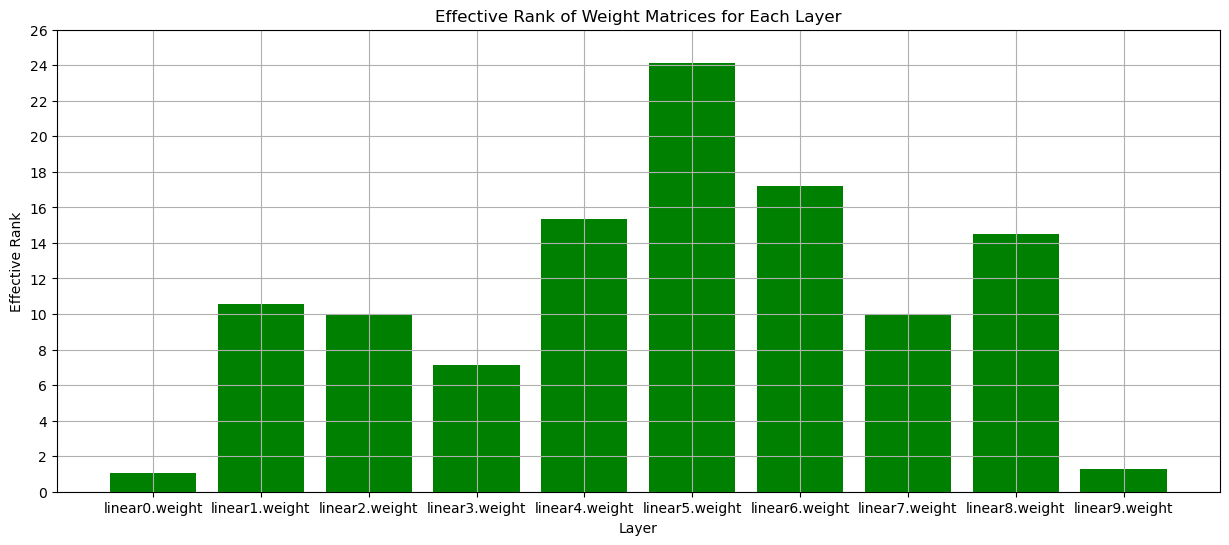

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    # print(np.sqrt(sigma_max / sigma_min))
    # print('----')
    return np.sqrt(sigma_max / sigma_min)

def plot_layer_effective_ranks(model):
    effective_ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


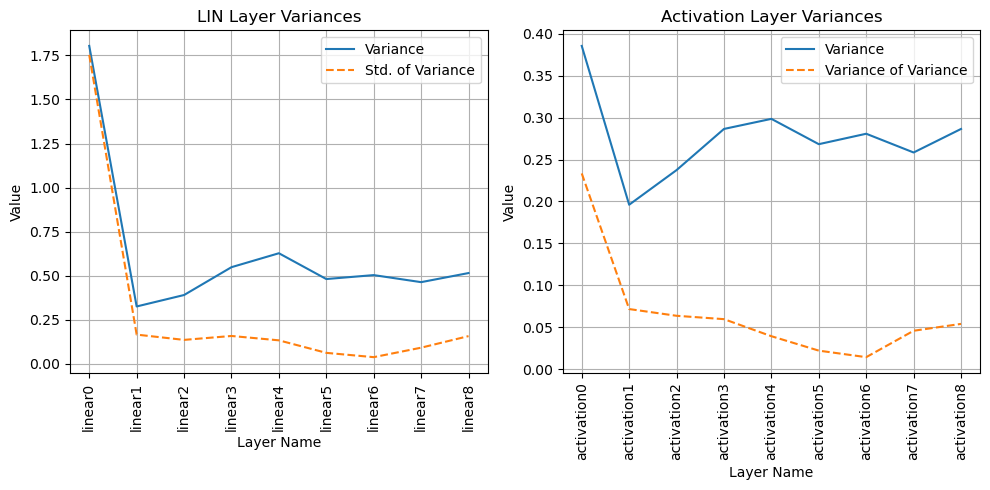

In [12]:
results, variances = compute_layer_variances_dense(model, test_loader, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

----

# Finetuning experiments

## Finetuning on two new classes while maintaining the old ones

In [13]:
from torch.utils.data import DataLoader, TensorDataset
import copy

def extend_model_for_new_classes(model, new_output_dim):

    new_model = copy.deepcopy(model)
    """
    Extend the model's output dimension for additional classes.
    """
    new_linear = torch.nn.Linear(new_model[-2].in_features, new_output_dim)
    new_linear.weight.data[:new_model[-2].out_features] = new_model[-2].weight.data
    new_linear.bias.data[:new_model[-2].out_features] = new_model[-2].bias.data
    
    new_model[-2] = new_linear

    return new_model

# Generate new data for additional classes
new_n_classes = 2  # Adding 2 more classes
new_shift = 2.0

# Find the maximum mean from the original data
max_original_mean = (n_classes - 1) * shift

# When generating new data, start from max_original_mean + desired_separation
desired_separation = 2.0
new_shift_start = max_original_mean + desired_separation

X_new, y_new = generate_data(new_n_classes, n_points, base_covariance, shift, new_shift_start)

y_new += n_classes  # Update labels for new classes

# Combine old and new data
X_combined = np.vstack([X, X_new])
y_combined = np.concatenate([y, y_new])

# Convert to PyTorch tensors
X_tensor_combined = torch.FloatTensor(X_combined)
y_tensor_combined = torch.LongTensor(y_combined)

# Create DataLoader for combined data
dataset_combined = TensorDataset(X_tensor_combined, y_tensor_combined)
train_loader_combined = DataLoader(dataset_combined, batch_size=32, shuffle=True)
test_loader_combined = DataLoader(dataset_combined, batch_size=32, shuffle=False)

# Update the model for the new classes
new_output_dim = n_classes + new_n_classes  # Original classes + new classes
finetuned_all_classes_model = extend_model_for_new_classes(model, new_output_dim)

# Update params and dataset namespace for new classes
params['depth'] = depth  # Make sure to set the correct depth
dataset_namespace_combined = SimpleNamespace(train_loader=train_loader_combined, test_loader=test_loader_combined, val_loader=test_loader_combined)

# Fine-tune and evaluate on new dataset
train_acc, test_acc, finetuned_all_classes_model, _ = compute_training_acc_epochs(finetuned_all_classes_model, dataset_namespace_combined, params, debug=True)

print(f"Fine-tuned Training Accuracy: {train_acc:.4f}")
print(f"Fine-tuned Test Accuracy: {test_acc:.4f}")


Epoch: 0 	Training Accuracy: 71.43%
Validation Accuracy: 71.43%
Epoch: 1 	Training Accuracy: 71.43%
Validation Accuracy: 71.43%
val_acc: 0.7142857142857143, max_val_acc: 0.7142857142857143, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 78.43%
Validation Accuracy: 78.43%
Epoch: 3 	Training Accuracy: 78.14%
Validation Accuracy: 78.14%
val_acc: 0.7814285714285715, max_val_acc: 0.7842857142857143, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 80.71%
Validation Accuracy: 80.71%
Epoch: 5 	Training Accuracy: 75.57%
Validation Accuracy: 75.57%
val_acc: 0.7557142857142857, max_val_acc: 0.8071428571428572, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 85.29%
Validation Accuracy: 85.29%
Epoch: 7 	Training Accuracy: 85.43%
Validation Accuracy: 85.43%
Epoch: 8 	Training Accuracy: 85.29%
Validation Accuracy: 85.29%
val_acc: 0.8528571428571429, max_val_acc: 0.8542857142857143, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 85.43%
Validation Accuracy: 85.43%
val_acc: 0.8542857142857143,

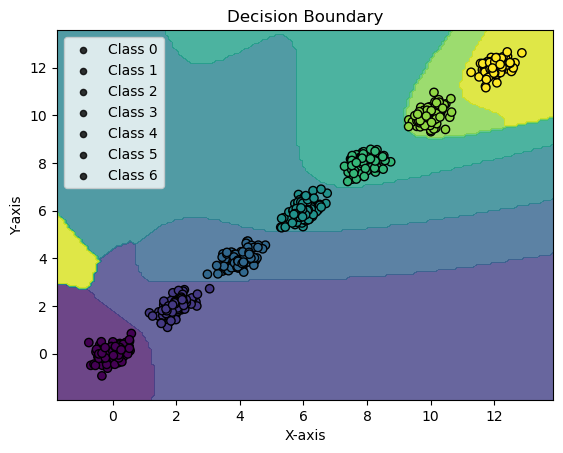


Train set: Average loss: 0.2881, Accuracy: 700.0/700 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       100
     Class 1       1.00      1.00      1.00       100
     Class 2       1.00      1.00      1.00       100
     Class 3       1.00      1.00      1.00       100
     Class 4       1.00      1.00      1.00       100
     Class 5       1.00      1.00      1.00       100
     Class 6       1.00      1.00      1.00       100

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



1.0

In [14]:
plot_decision_boundary(finetuned_all_classes_model, X_combined, y_combined, n_classes + new_n_classes)
eval(finetuned_all_classes_model, device, test_loader_combined, debug=True)

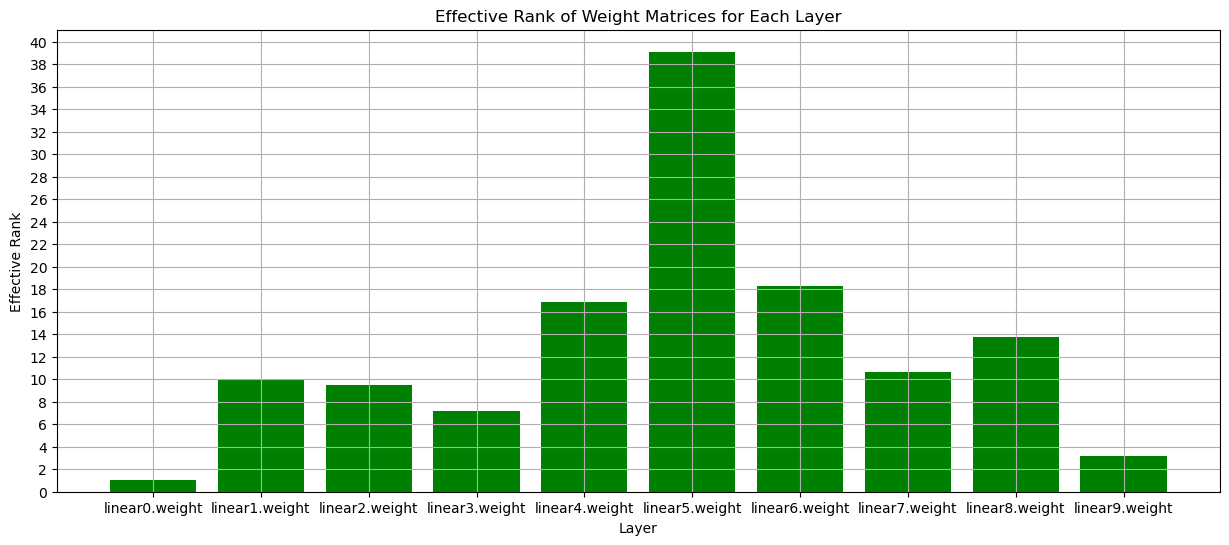

/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


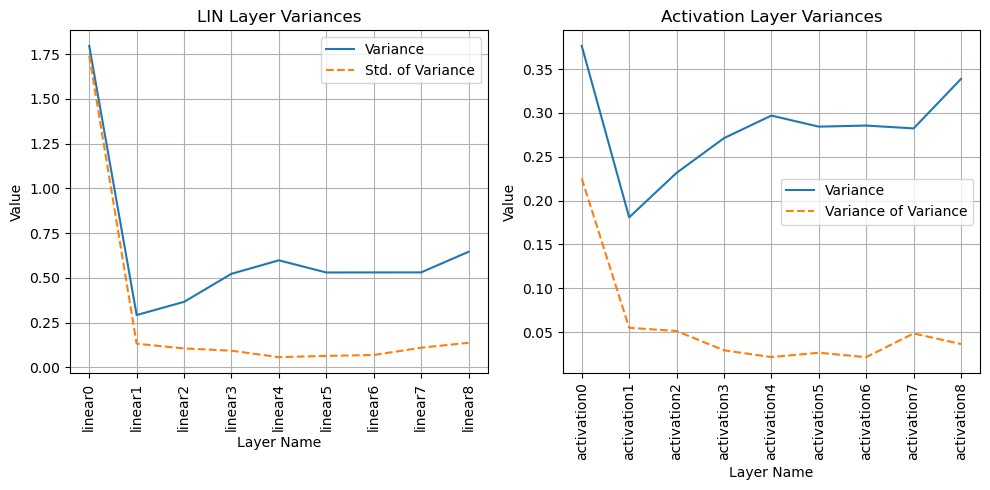

In [15]:
plot_layer_effective_ranks(finetuned_all_classes_model)
results, variances = compute_layer_variances_dense(finetuned_all_classes_model, test_loader, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

## Finetuning on two new classes while not using the old ones

In [17]:
# 1. Generate new classes without overlapping the previous ones

new_n_classes = 3  # For example, generate 3 new classes
max_original_mean = (n_classes - 1) * shift
desired_separation = 2.0
new_shift_start = max_original_mean + desired_separation

X_new, y_new = generate_data(new_n_classes, n_points, base_covariance, shift, new_shift_start)

# Convert to PyTorch tensors
X_tensor_new = torch.FloatTensor(X_new)
# Adjust the labels of new classes so that they don't overlap with the previous ones
y_tensor_new = torch.LongTensor(y_new + n_classes) 

# Create DataLoader for new data
dataset_new = TensorDataset(X_tensor_new, y_tensor_new)
train_loader_new = DataLoader(dataset_new, batch_size=32, shuffle=True)
test_loader_new = DataLoader(dataset_new, batch_size=32, shuffle=False)

# 2. Duplicate the existing model to ensure we're not overwriting the original

# Clone the model
model_new = copy.deepcopy(model)

# 3. Fine-tune on the new data

# Adjust output_dim for the new model to accommodate the new classes
new_output_layer = nn.Linear(params['width'], n_classes + new_n_classes)
setattr(model_new, f"linear{depth-1}", new_output_layer)

# You may also need to adjust the model's nn.Sequential structure to reflect this change
model_new[-2] = new_output_layer

dataset_namespace_new = SimpleNamespace(train_loader=train_loader_new, test_loader=test_loader_new, val_loader=test_loader_new)

# Train and evaluate the new model on the new data
train_acc_new, test_acc_new, model_new, _ = compute_training_acc_epochs(model_new, dataset_namespace_new, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")


Epoch: 0 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 1
Epoch: 1 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 2
Epoch: 2 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 3
Epoch: 3 	Training Accuracy: 0.00%
Validation Accuracy: 0.00%
val_acc: 0.0, max_val_acc: 0.0, no_improve_epochs: 4
Epoch: 4 	Training Accuracy: 1.00%
Validation Accuracy: 1.00%
Epoch: 5 	Training Accuracy: 19.33%
Validation Accuracy: 19.33%
Epoch: 6 	Training Accuracy: 25.33%
Validation Accuracy: 25.33%
Epoch: 7 	Training Accuracy: 31.67%
Validation Accuracy: 31.67%
Epoch: 8 	Training Accuracy: 32.33%
Validation Accuracy: 32.33%
Epoch: 9 	Training Accuracy: 32.67%
Validation Accuracy: 32.67%
Epoch: 10 	Training Accuracy: 32.67%
Validation Accuracy: 32.67%
val_acc: 0.32666666666666666, max_val_acc: 0.32666666666666666, no_improve_epochs: 1
Epoch: 1

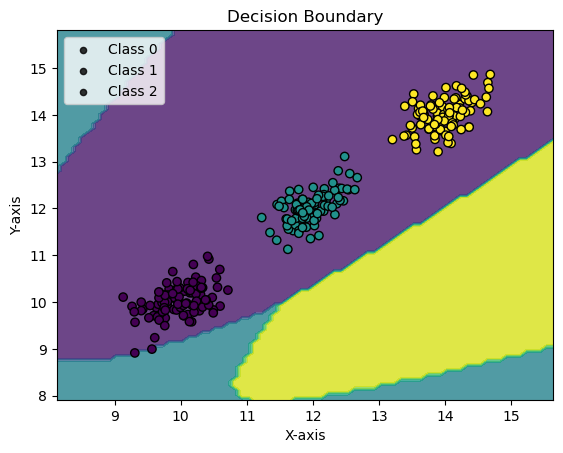


Train set: Average loss: 1.5032, Accuracy: 98.0/300 (33%)

              precision    recall  f1-score   support

     Class 0       0.33      0.98      0.49       100
     Class 1       0.00      0.00      0.00       100
     Class 2       0.00      0.00      0.00       100

    accuracy                           0.33       300
   macro avg       0.11      0.33      0.16       300
weighted avg       0.11      0.33      0.16       300



/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0.32666666666666666

In [20]:
plot_decision_boundary(model_new, X_new, y_new, new_n_classes)
eval(model_new, device, test_loader_new, debug=True)

In [345]:
# Assuming the above context is available...

# Generate new classes
new_n_classes = 3  # for example
max_original_mean = (n_classes - 1) * shift
desired_separation = 2.0
new_shift_start = max_original_mean + desired_separation
X_new, y_new = generate_data(new_n_classes, n_points, base_covariance, shift, new_shift_start)

# Convert new data to PyTorch tensors and adjust labels
y_new += n_classes  # increment labels so they don't overlap with original ones
X_tensor_new = torch.FloatTensor(X_new)
y_tensor_new = torch.LongTensor(y_new)

# Create new DataLoader for the new data
dataset_new = TensorDataset(X_tensor_new, y_tensor_new)
train_loader_new = DataLoader(dataset_new, batch_size=32, shuffle=True)
test_loader_new = DataLoader(dataset_new, batch_size=32, shuffle=False)

# Extend the output layer of the finetuned_only_new_model
finetuned_only_new_model = copy.deepcopy(finetuned_all_classes_model)
# Adjust the final layer to account for new classes
old_output_dim = getattr(finetuned_only_new_model, f"linear{depth-1}").out_features
new_output_dim = old_output_dim + new_n_classes

old_linear_layer = getattr(finetuned_only_new_model, f"linear{depth-1}")
setattr(finetuned_only_new_model, f"linear{depth-1}", nn.Linear(old_linear_layer.in_features, new_output_dim))


# Transfer finetuned_only_new_model to appropriate device
finetuned_only_new_model = finetuned_only_new_model.to(device)

######################
# Freeze all layers except the last one (classification head)
# for name, param in finetuned_only_new_model.named_parameters():
#     if f'linear{depth-1}' not in name:
#         param.requires_grad = False

# Update optimizer since we modified the finetuned_only_new_model
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, finetuned_only_new_model.parameters()), lr=params['lr'])
######################

# Create a 'Namespace' for the new dataset
dataset_namespace_new = SimpleNamespace(train_loader=train_loader_new, test_loader=test_loader_new, val_loader=test_loader_new)

# Train and evaluate using only the new data
train_acc, test_acc, finetuned_only_new_model, _ = compute_training_acc_epochs(finetuned_only_new_model, dataset_namespace_new, params, debug=True)

print(f"Finetuning on new classes - Training Accuracy: {train_acc:.4f}")
print(f"Finetuning on new classes - Test Accuracy: {test_acc:.4f}")


Epoch: 0 	Training Accuracy: 11.33%
Validation Accuracy: 11.33%
Epoch: 1 	Training Accuracy: 38.33%
Validation Accuracy: 38.33%
Epoch: 2 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.38333333333333336, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.38333333333333336, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.38333333333333336, no_improve_epochs: 3
Epoch: 5 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.38333333333333336, no_improve_epochs: 4
Epoch: 6 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.38333333333333336, no_improve_epochs: 5
Early stopping invoked.
Finetuning on new classes - Training Accuracy: 0.3333
Finetuning on new classes - Test Accuracy: 0.3333


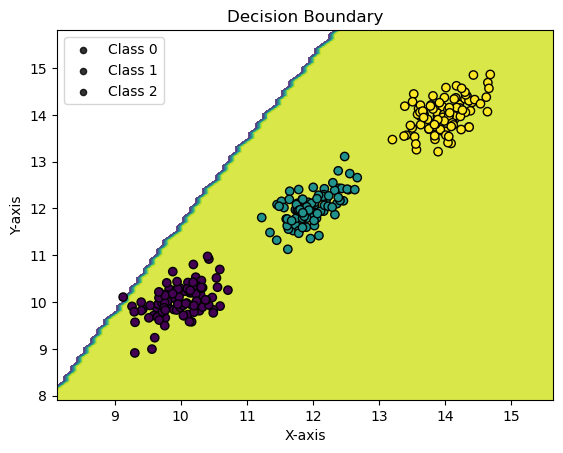


Train set: Average loss: 1.7756, Accuracy: 100.0/300 (33%)

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       100
     Class 1       0.00      0.00      0.00       100
     Class 2       0.33      1.00      0.50       100

    accuracy                           0.33       300
   macro avg       0.11      0.33      0.17       300
weighted avg       0.11      0.33      0.17       300



/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0.3333333333333333

In [346]:
plot_decision_boundary(finetuned_only_new_model, X_tensor_new, y_tensor_new, new_n_classes)
eval(finetuned_only_new_model, device, test_loader_new, debug=True)